##### Section 0: dependencies setup

In [330]:
import ucimlrepo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# importing keras libraries
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer

#### Section 1: dataset import

In [331]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
steel_plates_faults = fetch_ucirepo(id=198)

# data (as pandas dataframes) 
X = pd.DataFrame(steel_plates_faults.data.features)
y = pd.DataFrame(steel_plates_faults.data.targets)

#### Section 2: data analysis and preprocessing

In [332]:
# items i, ii and iii: checking consistency, missing values and type of data.
print(X.shape)
print(y.shape)

# # metadata 
# print(steel_plates_faults.metadata) 
  
# # variable information 
print(steel_plates_faults.variables) 

(1941, 27)
(1941, 7)
                     name     role        type demographic description units  \
0               X_Minimum  Feature     Integer        None        None  None   
1               X_Maximum  Feature     Integer        None        None  None   
2               Y_Minimum  Feature     Integer        None        None  None   
3               Y_Maximum  Feature     Integer        None        None  None   
4            Pixels_Areas  Feature     Integer        None        None  None   
5             X_Perimeter  Feature     Integer        None        None  None   
6             Y_Perimeter  Feature     Integer        None        None  None   
7       Sum_of_Luminosity  Feature     Integer        None        None  None   
8   Maximum_of_Luminosity  Feature     Integer        None        None  None   
9      Length_of_Conveyer  Feature     Integer        None        None  None   
10       TypeOfSteel_A300  Feature     Integer        None        None  None   
11       TypeOfStee

Upon initial examination, it appears that the dataset is consistent, with no missing values, and numeric distributions for all features, as expected.

Let's test out the dataset balance and the distribution of the target variables. 

In [333]:
# item iv: class distribution
print("Count of each class in target")
print(y.sum(axis=0))
print("Total: ", y.sum(axis=0).sum())

Count of each class in target
Pastry          158
Z_Scratch       190
K_Scratch       391
Stains           72
Dirtiness        55
Bumps           402
Other_Faults    673
dtype: int64
Total:  1941


As it's seem above, the dataset is not very well balanced. We could take care of this by using the SMOTE algorithm, that generates new samples for a certain smaller represented class by interpolating existing ones.

In [334]:
from imblearn.over_sampling import SMOTE

temp = SMOTE().fit_resample(X.to_numpy(), y.to_numpy())
X_over = pd.DataFrame(temp[0], columns=X.columns)
y_over = pd.DataFrame(temp[1], columns=y.columns)
print("Count of each class in target after SMOTE")
print(y_over.sum(axis=0))

Count of each class in target after SMOTE
Pastry          673
Z_Scratch       673
K_Scratch       673
Stains          673
Dirtiness       673
Bumps           673
Other_Faults    673
dtype: int64


In [362]:
# item v: data distribution and outlier handling
print("\nDescription of the dataset")
print(X.describe()[1:])


Description of the dataset
        X_Minimum    X_Maximum     Y_Minimum     Y_Maximum   Pixels_Areas  \
mean   571.136012   617.964451  1.650685e+06  1.650739e+06    1893.878413   
std    520.690671   497.627410  1.774578e+06  1.774590e+06    5168.459560   
min      0.000000     4.000000  6.712000e+03  6.724000e+03       2.000000   
25%     51.000000   192.000000  4.712530e+05  4.712810e+05      84.000000   
50%    435.000000   467.000000  1.204128e+06  1.204136e+06     174.000000   
75%   1053.000000  1072.000000  2.183073e+06  2.183084e+06     822.000000   
max   1705.000000  1713.000000  1.298766e+07  1.298769e+07  152655.000000   

       X_Perimeter   Y_Perimeter  Sum_of_Luminosity  Maximum_of_Luminosity  \
mean    111.855229     82.965997       2.063121e+05             130.193715   
std     301.209187    426.482879       5.122936e+05              18.690992   
min       2.000000      1.000000       2.500000e+02              37.000000   
25%      15.000000     13.000000       9.52


As for the values itself, we can see that a big set of features have outlier values. 
We could take care of this by just removing the outliers, but we would lose a great part of the data. Instead, we will be using RobustScaler to take care of this, also tackling the problem of the different scales of the features. Such a transformation is needed for the models we will be using (MLP), as they are sensitive to the scale of the features.

RobustScaler preprocesses the inputted data by scaling it based on the 25% and 75% quartiles, which helps to reduce the effect of outliers.

      X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
mean  -0.002589   0.028699   0.220299   0.220298      2.625673     1.345530   
std    0.539337   0.563072   1.133047   1.132983      8.458242     4.753362   
min   -0.681734  -0.748825  -0.882261  -0.882219     -0.311766    -0.445987   
25%   -0.544972  -0.497449  -0.499839  -0.499821     -0.164521    -0.193209   
50%    0.000000   0.000000   0.000000   0.000000      0.000000     0.000000   
75%    0.455028   0.502551   0.500161   0.500179      0.835479     0.806791   
max    1.214038   1.321955   7.688547   7.688091    320.794178   221.421845   

      Y_Perimeter  Sum_of_Luminosity  Maximum_of_Luminosity  \
mean     0.814044           2.676155              -0.022944   
std      5.287028           8.207571               0.984424   
min     -0.429637          -0.321240              -5.977015   
25%     -0.224159          -0.168447              -0.409352   
50%      0.000000           0.000000               0

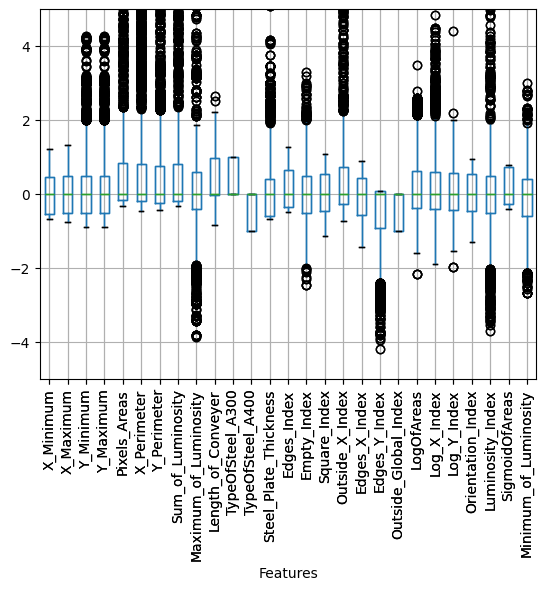

In [379]:
# item vi: data standardization
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler(quantile_range=(25, 75))
scaler.fit(X_over)

scaled_X = pd.DataFrame(scaler.transform(X_over), columns=X.columns)
# print(scaled_df)

print(scaled_X.describe()[1:])

# printing some boxplots for visualization

scaled_X.boxplot()
plt.ylim(-5, 5)
scaled_X.boxplot()
plt.xlabel('Features')
plt.xticks(rotation=90)

# plt.tight_layout()
plt.show()

The data, now, seems more centered around the origin, with similar scaled features.

   X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  X_Perimeter  \
0  -0.635035  -0.693087  -0.707828  -0.707775      0.245662    -0.127425   
1   0.035435   0.035139   0.789100   0.789055     -0.088795    -0.276087   
2   0.240023   0.258090   0.139295   0.139280     -0.166625    -0.318562   
3   0.266708   0.288382  -0.642813  -0.642762      0.054243    -0.212375   
4   0.751492   0.828797  -0.557832  -0.557647      4.751364     0.785786   

   Y_Perimeter  Sum_of_Luminosity  Maximum_of_Luminosity  Length_of_Conveyer  \
0     0.373598           0.146702              -1.449791            2.003960   
1     0.112079          -0.103628              -0.493336            2.003960   
2    -0.093399          -0.170491              -0.365808            1.609334   
3     0.392278           0.044719              -0.302044           -0.055494   
4     4.408452           4.494446              -0.302044           -0.055494   

   ...  Edges_X_Index  Edges_Y_Index  Outside_Global_Index  Lo

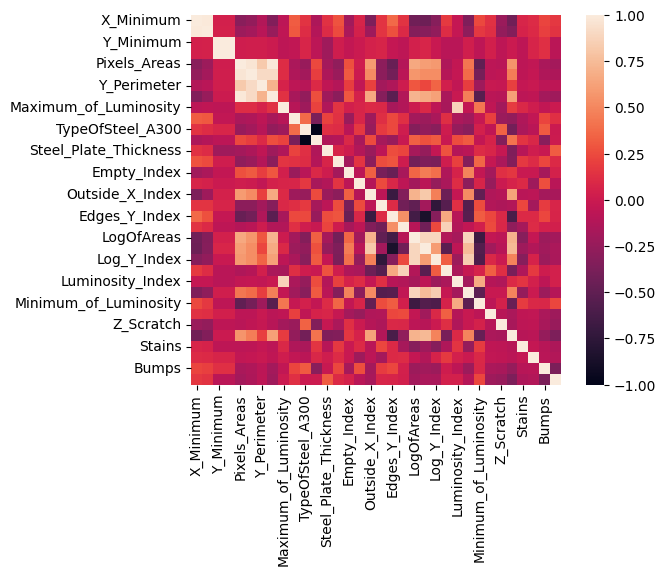

In [380]:
# item vii: feature minimization
print(scaled_X.head())

copy = X.copy().join(y)

corr = copy.select_dtypes('number').corr()
sns.heatmap(corr, annot=False, square=True)
plt.show()

One possible strategy was to get insights from this correlation matrix and remove some features that are highly correlated with others, but for now, we will keep all the features.

#### Section 3: partitioning the dataset

In [338]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y_over, test_size=0.3, random_state=43)

#### Section 4: implementing the model

In [339]:
model1 = Sequential()
model1.add(InputLayer(shape=(scaled_X.shape[1],)))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(7, activation='softmax'))

model1.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_61 (Dense)                │ (None, 128)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,487 (17.53 KB)

 Trainable params: 4,487 (17.53 KB)

 Non-trainable params: 0 (0.00 B)

In [340]:
# compiling the model
model1.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(),
        keras.metrics.CategoricalCrossentropy()
        ])

Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - categorical_accuracy: 0.5877 - categorical_crossentropy: 1.3728 - loss: 1.3728 - val_categorical_accuracy: 0.7751 - val_categorical_crossentropy: 0.7479 - val_loss: 0.7479
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - categorical_accuracy: 0.7950 - categorical_crossentropy: 0.6844 - loss: 0.6844 - val_categorical_accuracy: 0.7949 - val_categorical_crossentropy: 0.6038 - val_loss: 0.6038
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - categorical_accuracy: 0.8054 - categorical_crossentropy: 0.5613 - loss: 0.5613 - val_categorical_accuracy: 0.8098 - val_categorical_crossentropy: 0.5444 - val_loss: 0.5444
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - categorical_accuracy: 0.8231 - categorical_crossentropy: 0.5075 - loss: 0.5075 - val_categorical_accuracy: 0.8175 - val_categorical_crossentropy: 0.5038 - val_loss: 0.5038
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - categorical_accuracy: 0.8315 

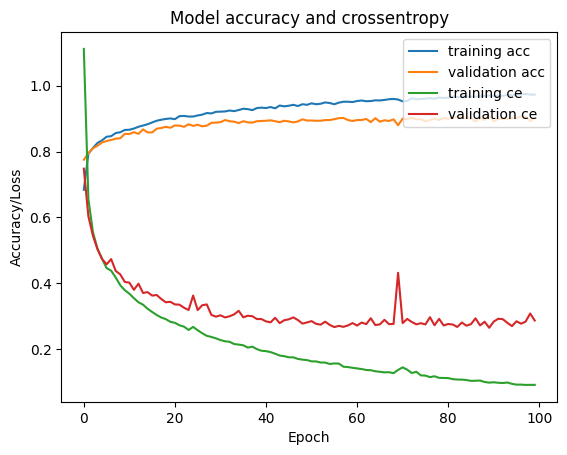

In [341]:
history = model1.fit(X_train, y_train, epochs=100, batch_size=25, validation_data=(X_test, y_test))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['categorical_crossentropy'])
plt.plot(history.history['val_categorical_crossentropy'])
plt.title('Model accuracy and crossentropy')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['training acc', 'validation acc', 'training ce', 'validation ce'], loc='upper right')
plt.show()

#### Section 5: conclusions

It can be seem that the model had a good performance, with good categorical accuracy on the validation set (~90%).
Nonetheless, it is important to know the reasons that led to this result:

##### i, ii. model complexity and hyperparameters

By choosing a non-linear model(MLP), we were able to capture the complexity of the dataset. However, this model is relatively sensitive to the hyperparameters, and it is important to tune them properly. If a higher complexity (more layers, more neurons per layer) was chosen, the model could have overfitted the data, and the results would not be as good as they are. On the other hand, if a simpler model was chosen, the model would not be able to capture the complexity of the dataset, and the results would not be as good as they are.

##### iii. dataset balance

By performing the SMOTE oversampling, we were able to surpass the limits imposed by the dataset imbalance, as this is also one of the reasons that could lead to a bad MLP performance. It's important to note that the SMOTE algorithm is not perfect, as it could generate samples that are not representative of the dataset.

##### iv. feature selection

It's certain that not always more features mean better results. By keeping all the features, we were able to capture the complexity of the dataset on its full extent. However, on larger datasets, it could be important to remove some features that are not relevant to the model, as they could lead to performance issues, or even overfitting.

On this specific dataset, by analyzing the correlation matrixes, it can be seem that some features are highly correlated with some targets classes, as for the _luminosity_ and _areas_ related ones.